In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.dqn.dqn import DQNTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [3]:
# Start ray locally (there are lots of configurations)
# to remote access ray dashboard, use ssh -L 8888:localhost:8265 local_host@xxx.xxx.xxx.xx
# on local: http://localhost:8888
ray.init(num_cpus=8, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

2020-03-12 14:17:22,819	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-12 14:17:22,821	INFO resource_spec.py:212 -- Starting Ray with 7.71 GiB memory available for workers and up to 3.86 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-12 14:17:23,169	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.236.176.76',
 'redis_address': '10.236.176.76:28175',
 'object_store_address': '/tmp/ray/session_2020-03-12_14-17-22_818951_15724/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-12_14-17-22_818951_15724/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-12_14-17-22_818951_15724'}

In [4]:
import json
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
# print(json.dumps(config, indent=2))

In [5]:
# change values at particular keys (note this could all come from yaml or json)
# ------- PPO ------
config['num_workers'] = 7
config['num_envs_per_worker'] = 5
config['sample_batch_size'] = 50
config['train_batch_size'] = 1000
config['num_gpus'] = 1
config['lambda'] = 0.95
config['kl_coeff']= 0.5
config["sgd_minibatch_size"] = 500
config["num_sgd_iter"]= 10
config["vf_share_layers"] = True
config['clip_rewards'] = True
config['clip_param']= 0.1
config['vf_clip_param']= 10.0
config['entropy_coeff'] = 0.01
config['model']['dim'] = 42
# config['model']['framestack'] = False
# config['model']['grayscale'] = True
# config['model']['zero_mean'] = False

# ---------DQN -------
# config['num_workers'] = 7
# config['num_envs_per_worker'] = 5
# config['sample_batch_size'] = 32
# config['train_batch_size'] = 256
# config['num_gpus'] = 1
# config["gamma"] = 0.99
# config["lr"] = 0.0001
# config["learning_starts"] = 10000
# config["buffer_size"] = 50000
# config['model']['dim'] = 42
# config['model']['grayscale'] = True
# config['model']['zero_mean'] = False
# config["exploration_config"]["epsilon_timesteps"] = 200000
# config["exploration_config"]["final_epsilon"] = .01


print(json.dumps(config, indent =2))

{
  "num_workers": 7,
  "num_envs_per_worker": 5,
  "sample_batch_size": 50,
  "batch_mode": "truncate_episodes",
  "num_gpus": 1,
  "train_batch_size": 1000,
  "model": {
    "conv_filters": null,
    "conv_activation": "relu",
    "fcnet_activation": "tanh",
    "fcnet_hiddens": [
      256,
      256
    ],
    "free_log_std": false,
    "no_final_linear": false,
    "vf_share_layers": true,
    "use_lstm": false,
    "max_seq_len": 20,
    "lstm_cell_size": 256,
    "lstm_use_prev_action_reward": false,
    "state_shape": null,
    "framestack": true,
    "dim": 42,
    "grayscale": false,
    "zero_mean": true,
    "custom_model": null,
    "custom_action_dist": null,
    "custom_options": {},
    "custom_preprocessor": null
  },
  "optimizer": {},
  "gamma": 0.99,
  "horizon": null,
  "soft_horizon": false,
  "no_done_at_end": false,
  "env_config": {},
  "env": null,
  "normalize_actions": false,
  "clip_rewards": true,
  "clip_actions": true,
  "preprocessor_pref": "deepmind",


In [7]:
# # agent = PPOTrainer(config, 'PongNoFrameskip-v4')
# agent = DQNTrainer(config, 'PongDeterministic-v4')

In [8]:
# for i in range(2000):
#     result = agent.train()
#     if i % 20 == 0:
#         print(pretty_print(result))
#     if i % 200 == 0:
#         checkpoint = agent.save()
#         print("checkpoint saved at", checkpoint)


In [10]:
# # the builder pattern is everywhere ...
# agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [14]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)
env = agent.workers.local_worker().env

<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>


In [15]:
print(env.observation_space)
print(env.action_space)
# print(env.observation_space.sample())

Box(42, 42, 4)
Discrete(6)


In [16]:
from ray.rllib.models.preprocessors import get_preprocessor
prep = get_preprocessor(env.observation_space)(env.observation_space, {"zero_mean":False,"dim":42, "grayscale":True})
print(prep.transform(env.observation_space.sample()).min())

0


In [17]:
# # compute some observation, then ask the agent to compute an action
# import cv2
# import numpy as np
# def preprocess(frame):
# #     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
# #     frame = cv2.resize(
# #         frame, (42, 42), interpolation=cv2.INTER_AREA)
# #     return frame[:, :, None]
#     scaled = frame[25:-25, :, :]
#     if 42 < 84:
#         scaled = cv2.resize(scaled, (84, 84))
#     # OpenAI: Resize by half, then down to 42x42 (essentially mipmapping).
#     # If we resize directly we lose pixels that, when mapped to 42x42,
#     # aren't close enough to the pixel boundary.
#     scaled = cv2.resize(scaled, (42, 42))
#     if True:
#         scaled = scaled.mean(2)
#         scaled = scaled.astype(np.float32)
#         # Rescale needed for maintaining 1 channel
#         scaled = np.reshape(scaled, [42, 42, 1])
#     if True:
#         scaled = (scaled - 128) / 128
#     else:
#         scaled *= 1.0 / 255.0
    
# #     print(scaled.shape)
#     return scaled



In [18]:
import gym
from gym import wrappers
from collections import deque

# env = agent.env_creator({})
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()

obs = env.observation_space.sample()
# frames = deque([], maxlen=4)
print(obs.shape)
accum = 0
for _ in range(10000):
#     obs = prep.transform(obs)
#     obs = preprocess(obs)
#     frames.append(obs)
    frames = obs
    
#     if len(frames) == 4:
#     action = agent.compute_action(np.concatenate(frames, axis=2))
    action = agent.compute_action(frames)
#     else:
#         action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    accum += reward
    if done: break
print(accum)
env.close()

(42, 42, 4)
20.0


In [19]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

In [11]:
# ## Save the agent off (this may become sticky depending which agent you've used)
# checkpoint_path = agent.save()
# print(checkpoint_path)

/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158


In [6]:
checkpoint_path = '/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158'
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
agent = PPOTrainer(trained_config, 'PongNoFrameskip-v4')
agent.restore(checkpoint_path) 


2020-03-12 14:17:42,588	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-12 14:17:42,605	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-12 14:17:48,485	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-12 14:17:48,592	WARNING trainable.py:210 -- Getting current IP.
2020-03-12 14:17:48,593	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158
2020-03-12 14:17:48,593	INFO trainable.py:423 -- Current state after restor

### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [24]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [25]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

     |████████████████████████████████| 13.1 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 1.4 MB/s eta 0:00:0101


In [40]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0")

In [41]:
df = analysis.dataframe() # last trial from checkpoint

In [43]:
df_trials = analysis.trial_dataframes['/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0']

<IPython.core.display.Javascript object>


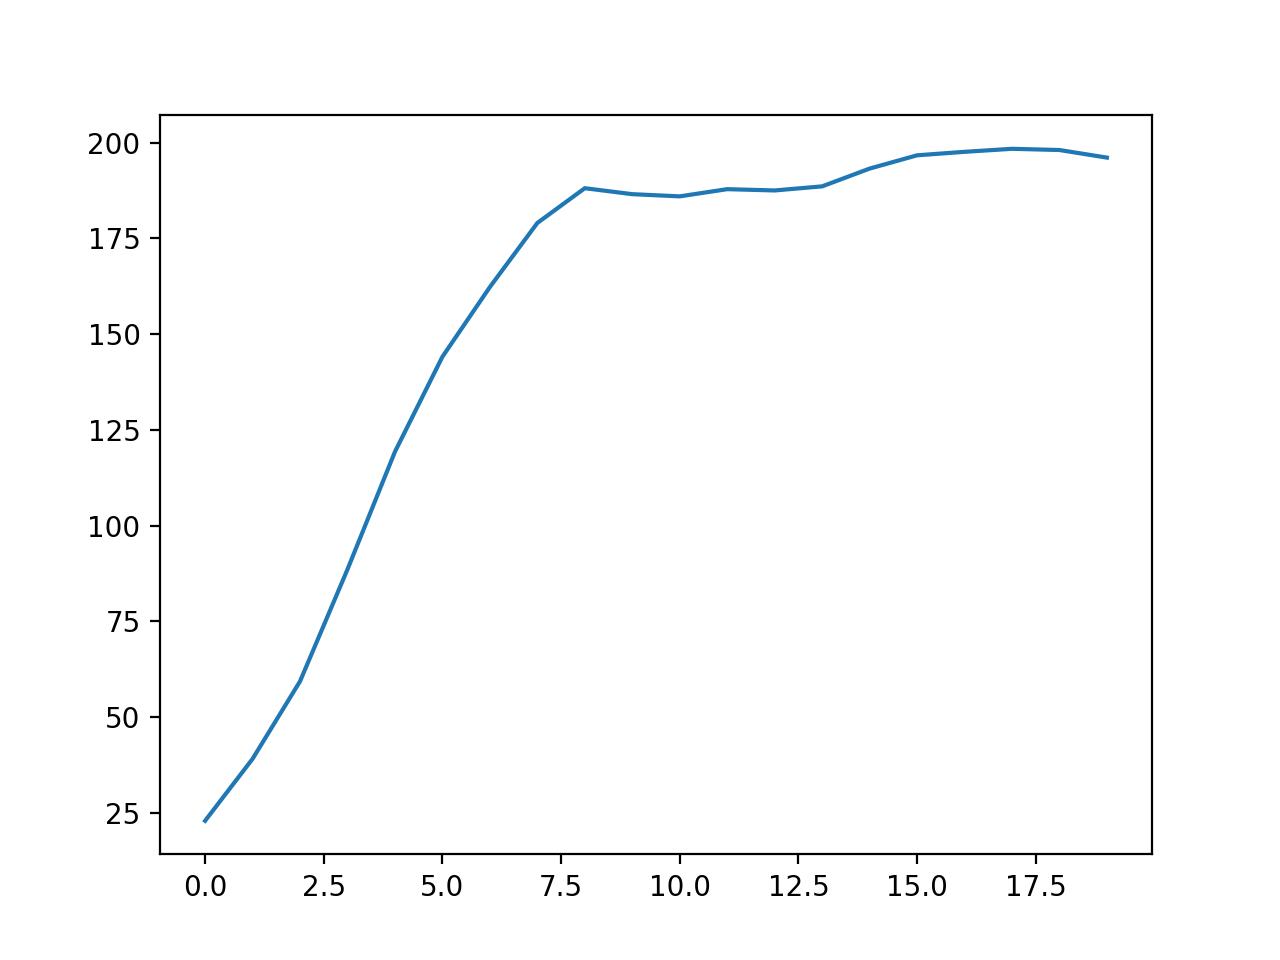

In [44]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [45]:
# ! pip install tensorboard

In [46]:
# ! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


In [13]:
import yaml
import urllib
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/ray/master/rllib/tuned_examples/pong-dqn.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# You can expect ~20 reward within 1.1m timesteps / 2.1 hours on a K80 GPU\npong-deterministic-dqn:\n    env: PongDeterministic-v4\n    run: DQN\n    stop:\n        episode_reward_mean: 20\n        time_total_s: 7200\n    config:\n        num_gpus: 1\n        gamma: 0.99\n        lr: .0001\n        learning_starts: 10000\n        buffer_size: 50000\n        sample_batch_size: 4\n        train_batch_size: 32\n        exploration_config:\n          epsilon_timesteps: 200000\n          final_epsilon: .01\n        model:\n          grayscale: True\n          zero_mean: False\n          dim: 42\n'


In [ ]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)
tune_config_example["pong-a3c"]["config"]["num_workers"]=2
tune_config_example["pong-a3c"]["stop"] = {"training_iteration": 10}
print(tune_config_example)

In [52]:
ray.is_initialized()

True

In [53]:
ray.nodes()

[{'NodeID': '41c26152d8eecc51f1a4fec2eec4a79eb681081f',
  'Alive': True,
  'NodeManagerAddress': '10.236.176.76',
  'NodeManagerHostname': 'qian-XPS-8920',
  'NodeManagerPort': 54719,
  'ObjectManagerPort': 46637,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/raylet',
  'Resources': {'node:10.236.176.76': 1.0,
   'object_store_memory': 25.0,
   'CPU': 8.0,
   'memory': 74.0,
   'GPU': 1.0},
  'alive': True}]

In [54]:
ray.cluster_resources()

{'node:10.236.176.76': 1.0,
 'object_store_memory': 25.0,
 'CPU': 8.0,
 'memory': 74.0,
 'GPU': 1.0}

In [55]:
ray.shutdown()

In [56]:
ray.is_initialized()

False